# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, Ridge, PoissonRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, root_mean_squared_error, max_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import patsy

pd.set_option("display.max_columns", None)

# Games Data

In [2]:
data_path = os.path.join("..", "data", "games.csv")
df = pd.read_csv(data_path, parse_dates=["Date", "Open"], date_format="%Y-%m-%d", index_col=0)

df = df[df["N"] == 0].drop(columns="N")
df["Timestamp"] = df["Date"].astype(int)
df = df[df["Season"] > 20]

display(df.head(), df.shape)

,Season,Date,HID,AID,POFF,Open,OddsH,OddsA,H,A,HSC,ASC,HFGM,AFGM,HFGA,AFGA,HFG3M,AFG3M,HFG3A,AFG3A,HFTM,AFTM,HFTA,AFTA,HORB,AORB,HDRB,ADRB,HRB,ARB,HAST,AAST,HSTL,ASTL,HBLK,ABLK,HTOV,ATOV,HPF,APF,Timestamp
23739,21,1995-11-07,0,11,0,1995-11-06,1.274083,3.794318,0,1,66,108,25.0,39.0,65.0,79.0,3.0,7.0,17.0,13.0,13.0,23.0,22.0,32.0,4.0,13.0,25.0,36.0,29.0,49.0,13.0,22.0,6.0,10.0,3.0,5.0,23.0,16.0,24.0,21.0,815702400000000000
23740,21,1995-11-07,17,43,0,1995-11-06,1.597972,2.286949,1,0,114,106,46.0,40.0,83.0,77.0,6.0,13.0,12.0,30.0,16.0,13.0,24.0,17.0,12.0,4.0,31.0,25.0,43.0,29.0,30.0,29.0,11.0,7.0,1.0,5.0,21.0,21.0,19.0,25.0,815702400000000000
23741,21,1995-11-08,41,39,0,1995-11-07,1.471072,2.640288,0,1,87,91,30.0,36.0,75.0,84.0,3.0,1.0,16.0,11.0,24.0,18.0,39.0,33.0,10.0,10.0,42.0,36.0,52.0,46.0,18.0,17.0,5.0,6.0,6.0,4.0,19.0,15.0,31.0,31.0,815788800000000000
23742,21,1995-11-08,15,22,0,1995-11-07,1.257454,3.967424,0,1,97,105,31.0,43.0,72.0,93.0,8.0,2.0,21.0,14.0,27.0,17.0,34.0,25.0,13.0,11.0,35.0,27.0,48.0,38.0,19.0,26.0,3.0,12.0,9.0,0.0,22.0,8.0,23.0,25.0,815788800000000000
23743,21,1995-11-08,13,19,0,1995-11-07,1.302199,3.542703,1,0,88,75,31.0,26.0,74.0,78.0,3.0,4.0,9.0,17.0,23.0,19.0,25.0,22.0,15.0,17.0,32.0,25.0,47.0,42.0,19.0,11.0,10.0,9.0,6.0,4.0,17.0,18.0,22.0,24.0,815788800000000000


(5251, 41)

In [3]:
meta_columns = ["Season", "Date", "HID", "AID", "POFF", "H", "A", "HSC", "ASC", "OddsH", "OddsA", "Timestamp"]
df_bare = df[meta_columns]

display(df_bare.head(), df_bare.shape)

,Season,Date,HID,AID,POFF,H,A,HSC,ASC,OddsH,OddsA,Timestamp
23739,21,1995-11-07,0,11,0,0,1,66,108,1.274083,3.794318,815702400000000000
23740,21,1995-11-07,17,43,0,1,0,114,106,1.597972,2.286949,815702400000000000
23741,21,1995-11-08,41,39,0,0,1,87,91,1.471072,2.640288,815788800000000000
23742,21,1995-11-08,15,22,0,0,1,97,105,1.257454,3.967424,815788800000000000
23743,21,1995-11-08,13,19,0,1,0,88,75,1.302199,3.542703,815788800000000000


(5251, 12)

In [4]:
rename_columnsH = {
    "HID": "TeamID", "AID": "OpponentID", "H": "W", "OddsH": "TeamOdds", "OddsA": "OpponentOdds", "POFF": "TeamPOFF",
    "HSC": "TeamSC", "HFGM": "TeamFGM", "HFGA": "TeamFGA", "HFG3M": "TeamFG3M", "HFG3A": "TeamFG3A", "HFTM": "TeamFTM", "HFTA": "TeamFTA", "HORB": "TeamORB", "HDRB": "TeamDRB", "HRB": "TeamRB", "HAST": "TeamAST", "HSTL": "TeamSTL", "HBLK": "TeamBLK", "HTOV": "TeamTOV", "HPF": "TeamPF",
    "ASC": "OpponentSC", "AFGM": "OpponentFGM", "AFGA": "OpponentFGA", "AFG3M": "OpponentFG3M", "AFG3A": "OpponentFG3A", "AFTM": "OpponentFTM", "AFTA": "OpponentFTA", "AORB": "OpponentORB", "ADRB": "OpponentDRB", "ARB": "OpponentRB", "AAST": "OpponentAST", "ASTL": "OpponentSTL", "ABLK": "OpponentBLK", "ATOV": "OpponentTOV", "APF": "OpponentPF",
}


df_home_game_stats = df.copy().drop(columns=["A", "Open"]).rename(columns=rename_columnsH)

display(df_home_game_stats.head().set_index(["Season", "Date", "TeamID", "OpponentID"]))


rename_columnsA = {
    "HID": "OpponentID", "AID": "TeamID", "A": "W", "OddsH": "OpponentOdds", "OddsA": "TeamOdds", "POFF": "TeamPOFF",
    "HSC": "OpponentSC", "HFGM": "OpponentFGM", "HFGA": "OpponentFGA", "HFG3M": "OpponentFG3M", "HFG3A": "OpponentFG3A", "HFTM": "OpponentFTM", "HFTA": "OpponentFTA", "HORB": "OpponentORB", "HDRB": "OpponentDRB", "HRB": "OpponentRB", "HAST": "OpponentAST", "HSTL": "OpponentSTL", "HBLK": "OpponentBLK", "HTOV": "OpponentTOV", "HPF": "OpponentPF",
    "ASC": "TeamSC", "AFGM": "TeamFGM", "AFGA": "TeamFGA", "AFG3M": "TeamFG3M", "AFG3A": "TeamFG3A", "AFTM": "TeamFTM", "AFTA": "TeamFTA", "AORB": "TeamORB", "ADRB": "TeamDRB", "ARB": "TeamRB", "AAST": "TeamAST", "ASTL": "TeamSTL", "ABLK": "TeamBLK", "ATOV": "TeamTOV", "APF": "TeamPF",
}


df_away_game_stats = df.copy().drop(columns=["H", "Open"]).rename(columns=rename_columnsA)

display(df_away_game_stats.head().set_index(["Season", "Date", "TeamID", "OpponentID"]))
features = [
    "TeamPOFF", "TeamOdds", "OpponentOdds", "W", "TeamSC", "OpponentSC", "TeamFGM", "OpponentFGM", "TeamFGA", "OpponentFGA", "TeamFG3M", "OpponentFG3M",
    "TeamFG3A", "OpponentFG3A", "TeamFTM", "OpponentFTM", "TeamFTA", "OpponentFTA", "TeamORB", "OpponentORB", "TeamDRB", "OpponentDRB", "TeamRB", "OpponentRB",
    "TeamAST", "OpponentAST", "TeamSTL", "OpponentSTL", "TeamBLK", "OpponentBLK", "TeamTOV", "OpponentTOV", "TeamPF", "OpponentPF"
]


df_home_game_stats["H"] = 1
df_away_game_stats["H"] = 0

df_game_stats = pd.concat([df_home_game_stats, df_away_game_stats])

display(df_game_stats.head(), df_game_stats.shape)

TeamPOFF  TeamOdds  OpponentOdds  W  \
Season Date       TeamID OpponentID                                        
21     1995-11-07 0      11                 0  1.274083      3.794318  0   
                  17     43                 0  1.597972      2.286949  1   
       1995-11-08 41     39                 0  1.471072      2.640288  0   
                  15     22                 0  1.257454      3.967424  0   
                  13     19                 0  1.302199      3.542703  1   

                                     TeamSC  OpponentSC  TeamFGM  OpponentFGM  \
Season Date       TeamID OpponentID                                             
21     1995-11-07 0      11              66         108     25.0         39.0   
                  17     43             114         106     46.0         40.0   
       1995-11-08 41     39              87          91     30.0         36.0   
                  15     22              97         105     31.0         43.0   
                  13     19              88          75     31.0         26.0   

                                     TeamFGA  OpponentFGA  TeamFG3M  \
Season Date       TeamID OpponentID                                   
21     1995-11-07 0      11             65.0         79.0       3.0   
                  17     43             83.0         77.0       6.0   
       1995-11-08 41     39             75.0         84.0       3.0   
                  15     22             72.0         93.0       8.0   
                  13     19             74.0         78.0       3.0   

                                     OpponentFG3M  TeamFG3A  OpponentFG3A  \
Season Date       TeamID OpponentID                                         
21     1995-11-07 0      11                   7.0      17.0          13.0   
                  17     43                  13.0      12.0          30.0   
       1995-11-08 41     39                   1.0      16.0          11.0   
                  15     22                   2.0      21.0          14.0   
                  13     19                   4.0       9.0          17.0   

                                     TeamFTM  OpponentFTM  TeamFTA  \
Season Date       TeamID OpponentID                                  
21     1995-11-07 0      11             13.0         23.0     22.0   
                  17     43             16.0         13.0     24.0   
       1995-11-08 41     39             24.0         18.0     39.0   
                  15     22             27.0         17.0     34.0   
                  13     19             23.0         19.0     25.0   

                                     OpponentFTA  TeamORB  OpponentORB  \
Season Date       TeamID OpponentID                                      
21     1995-11-07 0      11                 32.0      4.0         13.0   
                  17     43                 17.0     12.0          4.0   
       1995-11-08 41     39                 33.0     10.0         10.0   
                  15     22                 25.0     13.0         11.0   
                  13     19                 22.0     15.0         17.0   

                                     TeamDRB  OpponentDRB  TeamRB  OpponentRB  \
Season Date       TeamID OpponentID                                             
21     1995-11-07 0      11             25.0         36.0    29.0        49.0   
                  17     43             31.0         25.0    43.0        29.0   
       1995-11-08 41     39             42.0         36.0    52.0        46.0   
                  15     22             35.0         27.0    48.0        38.0   
                  13     19             32.0         25.0    47.0        42.0   

                                     TeamAST  OpponentAST  TeamSTL  \
Season Date       TeamID OpponentID                                  
21     1995-11-07 0      11             13.0         22.0      6.0   
                  17     43             30.0         29.0     11.0   
       1995-11-08 41     39             

TeamPOFF  OpponentOdds  TeamOdds  W  \
Season Date       TeamID OpponentID                                        
21     1995-11-07 11     0                  0      1.274083  3.794318  1   
                  43     17                 0      1.597972  2.286949  0   
       1995-11-08 39     41                 0      1.471072  2.640288  1   
                  22     15                 0      1.257454  3.967424  1   
                  19     13                 0      1.302199  3.542703  0   

                                     OpponentSC  TeamSC  OpponentFGM  TeamFGM  \
Season Date       TeamID OpponentID                                             
21     1995-11-07 11     0                   66     108         25.0     39.0   
                  43     17                 114     106         46.0     40.0   
       1995-11-08 39     41                  87      91         30.0     36.0   
                  22     15                  97     105         31.0     43.0   
                  19     13                  88      75         31.0     26.0   

                                     OpponentFGA  TeamFGA  OpponentFG3M  \
Season Date       TeamID OpponentID                                       
21     1995-11-07 11     0                  65.0     79.0           3.0   
                  43     17                 83.0     77.0           6.0   
       1995-11-08 39     41                 75.0     84.0           3.0   
                  22     15                 72.0     93.0           8.0   
                  19     13                 74.0     78.0           3.0   

                                     TeamFG3M  OpponentFG3A  TeamFG3A  \
Season Date       TeamID OpponentID                                     
21     1995-11-07 11     0                7.0          17.0      13.0   
                  43     17              13.0          12.0      30.0   
       1995-11-08 39     41               1.0          16.0      11.0   
                  22     15               2.0          21.0      14.0   
                  19     13               4.0           9.0      17.0   

                                     OpponentFTM  TeamFTM  OpponentFTA  \
Season Date       TeamID OpponentID                                      
21     1995-11-07 11     0                  13.0     23.0         22.0   
                  43     17                 16.0     13.0         24.0   
       1995-11-08 39     41                 24.0     18.0         39.0   
                  22     15                 27.0     17.0         34.0   
                  19     13                 23.0     19.0         25.0   

                                     TeamFTA  OpponentORB  TeamORB  \
Season Date       TeamID OpponentID                                  
21     1995-11-07 11     0              32.0          4.0     13.0   
                  43     17             17.0         12.0      4.0   
       1995-11-08 39     41             33.0         10.0     10.0   
                  22     15             25.0         13.0     11.0   
                  19     13             22.0         15.0     17.0   

                                     OpponentDRB  TeamDRB  OpponentRB  TeamRB  \
Season Date       TeamID OpponentID                                             
21     1995-11-07 11     0                  25.0     36.0        29.0    49.0   
                  43     17                 31.0     25.0        43.0    29.0   
       1995-11-08 39     41                 42.0     36.0        52.0    46.0   
                  22     15                 35.0     27.0        48.0    38.0   
                  19     13                 32.0     25.0        47.0    42.0   

                                     OpponentAST  TeamAST  OpponentSTL  \
Season Date       TeamID OpponentID                                      
21     1995-11-07 11     0                  13.0     22.0          6.0   
                  43     17                 30.0     29.0         11.0   
       1995-11-08 39    

,Season,Date,TeamID,OpponentID,TeamPOFF,TeamOdds,OpponentOdds,W,TeamSC,OpponentSC,TeamFGM,OpponentFGM,TeamFGA,OpponentFGA,TeamFG3M,OpponentFG3M,TeamFG3A,OpponentFG3A,TeamFTM,OpponentFTM,TeamFTA,OpponentFTA,TeamORB,OpponentORB,TeamDRB,OpponentDRB,TeamRB,OpponentRB,TeamAST,OpponentAST,TeamSTL,OpponentSTL,TeamBLK,OpponentBLK,TeamTOV,OpponentTOV,TeamPF,OpponentPF,Timestamp,H
23739,21,1995-11-07,0,11,0,1.274083,3.794318,0,66,108,25.0,39.0,65.0,79.0,3.0,7.0,17.0,13.0,13.0,23.0,22.0,32.0,4.0,13.0,25.0,36.0,29.0,49.0,13.0,22.0,6.0,10.0,3.0,5.0,23.0,16.0,24.0,21.0,815702400000000000,1
23740,21,1995-11-07,17,43,0,1.597972,2.286949,1,114,106,46.0,40.0,83.0,77.0,6.0,13.0,12.0,30.0,16.0,13.0,24.0,17.0,12.0,4.0,31.0,25.0,43.0,29.0,30.0,29.0,11.0,7.0,1.0,5.0,21.0,21.0,19.0,25.0,815702400000000000,1
23741,21,1995-11-08,41,39,0,1.471072,2.640288,0,87,91,30.0,36.0,75.0,84.0,3.0,1.0,16.0,11.0,24.0,18.0,39.0,33.0,10.0,10.0,42.0,36.0,52.0,46.0,18.0,17.0,5.0,6.0,6.0,4.0,19.0,15.0,31.0,31.0,815788800000000000,1
23742,21,1995-11-08,15,22,0,1.257454,3.967424,0,97,105,31.0,43.0,72.0,93.0,8.0,2.0,21.0,14.0,27.0,17.0,34.0,25.0,13.0,11.0,35.0,27.0,48.0,38.0,19.0,26.0,3.0,12.0,9.0,0.0,22.0,8.0,23.0,25.0,815788800000000000,1
23743,21,1995-11-08,13,19,0,1.302199,3.542703,1,88,75,31.0,26.0,74.0,78.0,3.0,4.0,9.0,17.0,23.0,19.0,25.0,22.0,15.0,17.0,32.0,25.0,47.0,42.0,19.0,11.0,10.0,9.0,6.0,4.0,17.0,18.0,22.0,24.0,815788800000000000,1


(10502, 40)

In [5]:
# Possessions
df_game_stats["TeamPoss"] = 0.5 * (df_game_stats["TeamFGA"] + 0.475 * df_game_stats["TeamFTA"] - df_game_stats["TeamORB"] + df_game_stats["TeamTOV"])
df_game_stats["OpponentPoss"] = 0.5 * (df_game_stats["OpponentFGA"] + 0.475 * df_game_stats["OpponentFTA"] - df_game_stats["OpponentORB"] + df_game_stats["OpponentTOV"])

# Offensive and Defensive Rating
df_game_stats["TeamORtg"] = df_game_stats["TeamSC"] / (df_game_stats["TeamPoss"] + df_game_stats["OpponentPoss"])
df_game_stats["TeamDRtg"] = df_game_stats["OpponentSC"] / (df_game_stats["TeamPoss"] + df_game_stats["OpponentPoss"])


display(df_game_stats[["Season", "Date", "TeamID", "OpponentID", "W", "TeamORtg", "TeamDRtg"]].head(), df_game_stats.shape)

df_team_season_stats = df_game_stats.groupby(["Season", "TeamID"]).mean()[["TeamORtg", "TeamDRtg"]].reset_index()
display(df_team_season_stats.head(), df_team_season_stats.shape)


df_game_stats["SC"] = (df_game_stats["TeamSC"] + df_game_stats["OpponentSC"]) / 2
df_season_stats = df_game_stats.groupby(["Season"]).agg(SCmean=("SC", "mean"), SCstd=("SC", "std")).reset_index()
display(df_season_stats.head(), df_season_stats.shape)



,Season,Date,TeamID,OpponentID,W,TeamORtg,TeamDRtg
23739,21,1995-11-07,0,11,0,0.688756,1.127055
23740,21,1995-11-07,17,43,1,1.109624,1.031756
23741,21,1995-11-08,41,39,0,0.839768,0.878378
23742,21,1995-11-08,15,22,0,0.974752,1.055144
23743,21,1995-11-08,13,19,1,0.992528,0.845904


(10502, 44)

,Season,TeamID,TeamORtg,TeamDRtg
0,21,0,1.005763,1.021105
1,21,1,1.018704,0.974275
2,21,2,1.033288,1.064689
3,21,3,1.031663,1.085368
4,21,4,1.054106,0.972278


(120, 4)

,Season,SCmean,SCstd
0,21,98.467914,10.537309
1,22,99.582129,10.850207
2,23,99.739163,10.608530
3,24,100.263338,9.799934


(4, 3)

In [6]:
df_features = pd.merge(
    df_bare, df_team_season_stats,
    left_on=["Season", "HID"], right_on=["Season", "TeamID"]
).drop(columns="TeamID")
df_features = pd.merge(
    df_features, df_team_season_stats,
    left_on=["Season", "AID"], right_on=["Season", "TeamID"], suffixes=("_H", "_A")
).drop(columns="TeamID")
df_features = pd.merge(df_features, df_season_stats, on=["Season"])
df_features["HSCadj"] = (df_features["HSC"] - df_features["SCmean"]) / df_features["SCstd"]
df_features["ASCadj"] = (df_features["ASC"] - df_features["SCmean"]) / df_features["SCstd"]
df_features["SCdiff"] = df_features["HSC"] - df_features["ASC"]


display(df_features.head(), df_features.shape)

,Season,Date,HID,AID,POFF,H,A,HSC,ASC,OddsH,OddsA,Timestamp,TeamORtg_H,TeamDRtg_H,TeamORtg_A,TeamDRtg_A,SCmean,SCstd,HSCadj,ASCadj,SCdiff
0,21,1995-11-07,0,11,0,0,1,66,108,1.274083,3.794318,815702400000000000,1.005763,1.021105,1.011451,0.963977,98.467914,10.537309,-3.081234,0.904603,-42
1,21,1996-03-13,0,11,0,1,0,103,70,1.595060,2.293425,826675200000000000,1.005763,1.021105,1.011451,0.963977,98.467914,10.537309,0.430099,-2.701630,33
2,21,1996-05-03,0,11,1,0,1,96,104,2.043143,1.731877,831081600000000000,1.005763,1.021105,1.011451,0.963977,98.467914,10.537309,-0.234207,0.525000,-8
3,21,1996-05-05,0,11,1,0,1,79,92,2.147690,1.667978,831254400000000000,1.005763,1.021105,1.011451,0.963977,98.467914,10.537309,-1.847522,-0.613811,-13
4,21,1995-11-26,17,11,0,1,0,82,72,1.499747,2.545381,817344000000000000,1.044545,1.051904,1.011451,0.963977,98.467914,10.537309,-1.562820,-2.511829,10


(5251, 21)

In [7]:
formula_H = "H ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_H)

model = smf.logit(formula=formula_H, data=df_features)
result = model.fit()

display(result.summary())

model = smf.ols(formula=formula_H, data=df_features)
result = model.fit()

display(result.summary())



H ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A
Optimization terminated successfully.
         Current function value: 0.571364
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      H   No. Observations:                 5251
Model:                          Logit   Df Residuals:                     5246
Method:                           MLE   Df Model:                            4
Date:                Thu, 07 Nov 2024   Pseudo R-squ.:                  0.1489
Time:                        19:03:12   Log-Likelihood:                -3000.2
converged:                       True   LL-Null:                       -3525.1
Covariance Type:            nonrobust   LLR p-value:                5.803e-226
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0174      2.194     -1.375      0.169      -7.317       1.282
TeamORtg_H    17.7694      1.084     16.395      0.000      15.645      19.894
TeamDRtg_H   -16.1713      1.082    -14.950      0.000     -18.291     -14.051
TeamORtg_A   -13.9293      1.060    -13.141      0.000     -16.007     -11.852
TeamDRtg_A    15.7407      1.065     14.784      0.000      13.654      17.827
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      H   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     292.8
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.30e-227
Time:                        19:03:12   Log-Likelihood:                -3165.7
No. Observations:                5251   AIC:                             6341.
Df Residuals:                    5246   BIC:                             6374.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1125      0.431     -0.261      0.794      -0.957       0.732
TeamORtg_H     3.5208      0.201     17.490      0.000       3.126       3.915
TeamDRtg_H    -3.2432      0.203    -16.015      0.000      -3.640      -2.846
TeamORtg_A    -2.7005      0.201    -13.404      0.000      -3.096      -2.306
TeamDRtg_A     3.1134      0.203     15.341      0.000       2.716       3.511
==============================================================================
Omnibus:                     4899.560   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              398.943
Skew:                          -0.302   Prob(JB):                     2.35e-87
Kurtosis:                       1.792   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
formula_HSC = "HSC ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_HSC)

model = smf.ols(formula=formula_HSC, data=df_features)
result = model.fit()

display(result.summary())

formula_ASC = "ASC ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_ASC)

model = smf.ols(formula=formula_ASC, data=df_features)
result = model.fit()

display(result.summary())


HSC ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    HSC   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     285.9
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.09e-222
Time:                        19:03:12   Log-Likelihood:                -20235.
No. Observations:                5251   AIC:                         4.048e+04
Df Residuals:                    5246   BIC:                         4.051e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -183.4735     11.115    -16.506      0.000    -205.264    -161.683
TeamORtg_H   118.3833      5.196     22.786      0.000     108.198     128.569
TeamDRtg_H    33.5754      5.227      6.424      0.000      23.329      43.822
TeamORtg_A     0.7930      5.200      0.152      0.879      -9.401      10.987
TeamDRtg_A   121.6726      5.238     23.229      0.000     111.404     131.941
==============================================================================
Omnibus:                       91.677   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.477
Skew:                           0.247   Prob(JB):                     1.39e-25
Kurtosis:                       3.528   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ASC ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ASC   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     261.9
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.77e-205
Time:                        19:03:12   Log-Likelihood:                -20096.
No. Observations:                5251   AIC:                         4.020e+04
Df Residuals:                    5246   BIC:                         4.023e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -171.6704     10.823    -15.861      0.000    -192.889    -150.452
TeamORtg_H    11.8146      5.059      2.335      0.020       1.897      21.732
TeamDRtg_H   133.2659      5.089     26.185      0.000     123.288     143.243
TeamORtg_A    86.3385      5.063     17.051      0.000      76.412      96.265
TeamDRtg_A    28.5158      5.100      5.591      0.000      18.517      38.515
==============================================================================
Omnibus:                       62.219   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.991
Skew:                           0.202   Prob(JB):                     8.57e-17
Kurtosis:                       3.419   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
formula_SCdiff = "SCdiff ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_SCdiff)

model = smf.ols(formula=formula_SCdiff, data=df_features)
result = model.fit()

display(result.summary())

SCdiff ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SCdiff   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     400.0
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          3.79e-301
Time:                        19:03:12   Log-Likelihood:                -20307.
No. Observations:                5251   AIC:                         4.062e+04
Df Residuals:                    5246   BIC:                         4.066e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.8031     11.268     -1.047      0.295     -33.893      10.287
TeamORtg_H   106.5687      5.267     20.234      0.000      96.244     116.894
TeamDRtg_H   -99.6905      5.299    -18.815      0.000    -110.078     -89.303
TeamORtg_A   -85.5455      5.271    -16.228      0.000     -95.880     -75.211
TeamDRtg_A    93.1568      5.310     17.544      0.000      82.747     103.567
==============================================================================
Omnibus:                       19.181   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.842
Skew:                          -0.032   Prob(JB):                     4.03e-06
Kurtosis:                       3.331   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
formula_HSCadj = "HSCadj ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_HSCadj)

model = smf.ols(formula=formula_HSCadj, data=df_features)
result = model.fit()

display(result.summary())

formula_ASCadj = "ASCadj ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A"

print(formula_ASCadj)

model = smf.ols(formula=formula_ASCadj, data=df_features)
result = model.fit()

display(result.summary())


HSCadj ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 HSCadj   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     263.4
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.53e-206
Time:                        19:03:12   Log-Likelihood:                -7951.0
No. Observations:                5251   AIC:                         1.591e+04
Df Residuals:                    5246   BIC:                         1.594e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.4361      1.071    -23.743      0.000     -27.536     -23.336
TeamORtg_H    10.9240      0.501     21.816      0.000       9.942      11.906
TeamDRtg_H     2.7909      0.504      5.540      0.000       1.803       3.779
TeamORtg_A    -0.3173      0.501     -0.633      0.527      -1.300       0.665
TeamDRtg_A    11.2774      0.505     22.338      0.000      10.288      12.267
==============================================================================
Omnibus:                       86.923   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.298
Skew:                           0.242   Prob(JB):                     5.02e-24
Kurtosis:                       3.507   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ASCadj ~ TeamORtg_H + TeamDRtg_H + TeamORtg_A + TeamDRtg_A


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ASCadj   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     238.3
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          2.77e-188
Time:                        19:03:12   Log-Likelihood:                -7798.7
No. Observations:                5251   AIC:                         1.561e+04
Df Residuals:                    5246   BIC:                         1.564e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -24.2246      1.041    -23.278      0.000     -26.265     -22.184
TeamORtg_H     0.7221      0.486      1.485      0.138      -0.231       1.676
TeamDRtg_H    12.2811      0.489     25.096      0.000      11.322      13.240
TeamORtg_A     7.8514      0.487     16.127      0.000       6.897       8.806
TeamDRtg_A     2.3554      0.490      4.803      0.000       1.394       3.317
==============================================================================
Omnibus:                       62.928   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.113
Skew:                           0.211   Prob(JB):                     1.33e-16
Kurtosis:                       3.395   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
df_train, df_test = train_test_split(df_features, test_size=0.25)

model_lr = LogisticRegression(max_iter=1000)
model_ridge = Ridge(max_iter=1000)
model_poisson = PoissonRegressor(max_iter=1000)
model_nb = GaussianNB() 

y_train_H, X_train_H = patsy.dmatrices(formula_H, df_train, return_type="matrix")
y_test_H, X_test_H = patsy.dmatrices(formula_H, df_test, return_type="matrix")

y_train_HSC, X_train_HSC = patsy.dmatrices(formula_HSC, df_train, return_type="matrix")
y_test_HSC, X_test_HSC = patsy.dmatrices(formula_HSC, df_test, return_type="matrix")

y_train_ASC, X_train_ASC = patsy.dmatrices(formula_ASC, df_train, return_type="matrix")
y_test_ASC, X_test_ASC = patsy.dmatrices(formula_ASC, df_test, return_type="matrix")

y_train_HSCadj, X_train_HSCadj = patsy.dmatrices(formula_HSCadj, df_train, return_type="matrix")
y_test_HSCadj, X_test_HSCadj = patsy.dmatrices(formula_HSCadj, df_test, return_type="matrix")

y_train_ASCadj, X_train_ASCadj = patsy.dmatrices(formula_ASCadj, df_train, return_type="matrix")
y_test_ASCadj, X_test_ASCadj = patsy.dmatrices(formula_ASCadj, df_test, return_type="matrix")

y_train_SCdiff, X_train_SCdiff = patsy.dmatrices(formula_SCdiff, df_train, return_type="matrix")
y_test_SCdiff, X_test_SCdiff = patsy.dmatrices(formula_SCdiff, df_test, return_type="matrix")


y_train_H = y_train_H.flatten()
y_test_H = y_test_H.flatten()

y_train_HSC = y_train_HSC.flatten()
y_test_HSC = y_test_HSC.flatten()

y_train_ASC = y_train_ASC.flatten()
y_test_ASC = y_test_ASC.flatten()

y_train_HSCadj = y_train_HSCadj.flatten()
y_test_HSCadj = y_test_HSCadj.flatten()

y_train_ASCadj = y_train_ASCadj.flatten()
y_test_ASCadj = y_test_ASCadj.flatten()

y_train_SCdiff = y_train_SCdiff.flatten()
y_test_SCdiff = y_test_SCdiff.flatten()


model_lr.fit(X_train_H, y_train_H)
model_ridge.fit(X_train_H, y_train_H)
model_nb.fit(X_train_H, y_train_H)
predictions_lr_train_H = model_lr.predict(X_train_H)
predictions_lr_test_H = model_lr.predict(X_test_H)
predictions_ridge_train_H = model_ridge.predict(X_train_H)
predictions_ridge_test_H = model_ridge.predict(X_test_H)
predictions_nb_train_H = model_nb.predict(X_train_H)
predictions_nb_test_H = model_nb.predict(X_test_H)


model_ridge.fit(X_train_HSC, y_train_HSC)
model_poisson.fit(X_train_HSC, y_train_HSC)
predictions_ridge_train_HSC = model_ridge.predict(X_train_HSC)
predictions_ridge_test_HSC = model_ridge.predict(X_test_HSC)
predictions_poisson_train_HSC = model_poisson.predict(X_train_HSC)
predictions_poisson_test_HSC = model_poisson.predict(X_test_HSC)


model_ridge.fit(X_train_ASC, y_train_ASC)
model_poisson.fit(X_train_ASC, y_train_ASC)
predictions_ridge_train_ASC = model_ridge.predict(X_train_ASC)
predictions_ridge_test_ASC = model_ridge.predict(X_test_ASC)
predictions_poisson_train_ASC = model_poisson.predict(X_train_ASC)
predictions_poisson_test_ASC = model_poisson.predict(X_test_ASC)

model_ridge.fit(X_train_HSCadj, y_train_HSCadj)
predictions_ridge_train_HSCadj = model_ridge.predict(X_train_HSCadj)
predictions_ridge_test_HSCadj = model_ridge.predict(X_test_HSCadj)

model_ridge.fit(X_train_ASCadj, y_train_ASCadj)
predictions_ridge_train_ASCadj = model_ridge.predict(X_train_ASCadj)
predictions_ridge_test_ASCadj = model_ridge.predict(X_test_ASCadj)

model_ridge.fit(X_train_SCdiff, y_train_SCdiff)
predictions_ridge_train_SCdiff = model_ridge.predict(X_train_SCdiff)
predictions_ridge_test_SCdiff = model_ridge.predict(X_test_SCdiff)


accuracy_lr_train_H = accuracy_score(y_train_H, predictions_lr_train_H)
accuracy_lr_test_H = accuracy_score(y_test_H, predictions_lr_test_H)
accuracy_nb_train_H = accuracy_score(y_train_H, predictions_nb_train_H)
accuracy_nb_test_H = accuracy_score(y_test_H, predictions_nb_test_H)
accuracy_ridge_train_H = accuracy_score(y_train_H, predictions_ridge_train_H > 0.5)
accuracy_ridge_test_H = accuracy_score(y_test_H, predictions_ridge_test_H > 0.5)
rmse_ridge_train_H = root_mean_squared_error(y_train_H, predictions_ridge_train_H)
rmse_ridge_test_H = root_mean_squared_error(y_test_H, predictions_ridge_test_H)

rmse_ridge_train_HSC = root_mean_squared_error(y_train_HSC, predictions_ridge_train_HSC)
rmse_ridge_test_HSC = root_mean_squared_error(y_test_HSC, predictions_ridge_test_HSC)
rmse_poisson_train_HSC = root_mean_squared_error(y_train_HSC, predictions_poisson_train_HSC)
rmse_poisson_test_HSC = root_mean_squared_error(y_test_HSC, predictions_poisson_test_HSC)
maxe_ridge_train_HSC = max_error(y_train_HSC, predictions_ridge_train_HSC)
maxe_ridge_test_HSC = max_error(y_test_HSC, predictions_ridge_test_HSC)
maxe_poisson_train_HSC = max_error(y_train_HSC, predictions_poisson_train_HSC)
maxe_poisson_test_HSC = max_error(y_test_HSC, predictions_poisson_test_HSC)
mae_ridge_train_HSC = mean_absolute_error(y_train_HSC, predictions_ridge_train_HSC)
mae_ridge_test_HSC = mean_absolute_error(y_test_HSC, predictions_ridge_test_HSC)
mae_poisson_train_HSC = mean_absolute_error(y_train_HSC, predictions_poisson_train_HSC)
mae_poisson_test_HSC = mean_absolute_error(y_test_HSC, predictions_poisson_test_HSC)

rmse_ridge_train_ASC = root_mean_squared_error(y_train_ASC, predictions_ridge_train_ASC)
rmse_ridge_test_ASC = root_mean_squared_error(y_test_ASC, predictions_ridge_test_ASC)
rmse_poisson_train_ASC = root_mean_squared_error(y_train_ASC, predictions_poisson_train_ASC)
rmse_poisson_test_ASC = root_mean_squared_error(y_test_ASC, predictions_poisson_test_ASC)
maxe_ridge_train_ASC = max_error(y_train_ASC, predictions_ridge_train_ASC)
maxe_ridge_test_ASC = max_error(y_test_ASC, predictions_ridge_test_ASC)
maxe_poisson_train_ASC = max_error(y_train_ASC, predictions_poisson_train_ASC)
maxe_poisson_test_ASC = max_error(y_test_ASC, predictions_poisson_test_ASC)
mae_ridge_train_ASC = mean_absolute_error(y_train_ASC, predictions_ridge_train_ASC)
mae_ridge_test_ASC = mean_absolute_error(y_test_ASC, predictions_ridge_test_ASC)
mae_poisson_train_ASC = mean_absolute_error(y_train_ASC, predictions_poisson_train_ASC)
mae_poisson_test_ASC = mean_absolute_error(y_test_ASC, predictions_poisson_test_ASC)

accuracy_ridge_train_SC = accuracy_score(y_train_H, predictions_ridge_train_HSC > predictions_ridge_train_ASC)
accuracy_ridge_test_SC = accuracy_score(y_test_H, predictions_ridge_test_HSC > predictions_ridge_test_ASC)
accuracy_poisson_train_SC = accuracy_score(y_train_H, predictions_poisson_train_HSC > predictions_poisson_train_ASC)
accuracy_poisson_test_SC = accuracy_score(y_test_H, predictions_poisson_test_HSC > predictions_poisson_test_ASC)

rmse_ridge_train_HSCadj = root_mean_squared_error(y_train_HSCadj, predictions_ridge_train_HSCadj)
rmse_ridge_test_HSCadj = root_mean_squared_error(y_test_HSCadj, predictions_ridge_test_HSCadj)
maxe_ridge_train_HSCadj = max_error(y_train_HSCadj, predictions_ridge_train_HSCadj)
maxe_ridge_test_HSCadj = max_error(y_test_HSCadj, predictions_ridge_test_HSCadj)
mae_ridge_train_HSCadj = mean_absolute_error(y_train_HSCadj, predictions_ridge_train_HSCadj)
mae_ridge_test_HSCadj = mean_absolute_error(y_test_HSCadj, predictions_ridge_test_HSCadj)

rmse_ridge_train_ASCadj = root_mean_squared_error(y_train_ASCadj, predictions_ridge_train_ASCadj)
rmse_ridge_test_ASCadj = root_mean_squared_error(y_test_ASCadj, predictions_ridge_test_ASCadj)
maxe_ridge_train_ASCadj = max_error(y_train_ASCadj, predictions_ridge_train_ASCadj)
maxe_ridge_test_ASCadj = max_error(y_test_ASCadj, predictions_ridge_test_ASCadj)
mae_ridge_train_ASCadj = mean_absolute_error(y_train_ASCadj, predictions_ridge_train_ASCadj)
mae_ridge_test_ASCadj = mean_absolute_error(y_test_ASCadj, predictions_ridge_test_ASCadj)

accuracy_ridge_train_SCadj = accuracy_score(y_train_H, predictions_ridge_train_HSCadj > predictions_ridge_train_ASCadj)
accuracy_ridge_test_SCadj = accuracy_score(y_test_H, predictions_ridge_test_HSCadj > predictions_ridge_test_ASCadj)

rmse_ridge_train_SCdiff = root_mean_squared_error(y_train_SCdiff, predictions_ridge_train_SCdiff)
rmse_ridge_test_SCdiff = root_mean_squared_error(y_test_SCdiff, predictions_ridge_test_SCdiff)
maxe_ridge_train_SCdiff = max_error(y_train_SCdiff, predictions_ridge_train_SCdiff)
maxe_ridge_test_SCdiff = max_error(y_test_SCdiff, predictions_ridge_test_SCdiff)
mae_ridge_train_SCdiff = mean_absolute_error(y_train_SCdiff, predictions_ridge_train_SCdiff)
mae_ridge_test_SCdiff = mean_absolute_error(y_test_SCdiff, predictions_ridge_test_SCdiff)
accuracy_ridge_train_SCdiff = accuracy_score(y_train_H, predictions_ridge_train_SCdiff > 0)
accuracy_ridge_test_SCdiff = accuracy_score(y_test_H, predictions_ridge_test_SCdiff > 0)


print(f"H - LR - Train Acc: {accuracy_lr_train_H :.2%}, Test Acc: {accuracy_lr_test_H :.2%}")
print(f"H - NB - Train Acc: {accuracy_nb_train_H :.2%}, Test Acc: {accuracy_nb_test_H :.2%}")
print(f"H - Ridge - Train Acc: {accuracy_ridge_train_H :.2%}, Test Acc: {accuracy_ridge_test_H :.2%}, Train RMSE: {rmse_ridge_train_H :.3f}, Test RMSE: {rmse_ridge_test_H :.3f}")
print(f"HSC - Ridge - Train RMSE: {rmse_ridge_train_HSC :.3f}, Test RMSE: {rmse_ridge_test_HSC :.3f}, Train MAE: {mae_ridge_train_HSC :.3f}, Test MAE: {mae_ridge_test_HSC :.3f}, Train MaxE: {maxe_ridge_train_HSC :.3f}, Test MaxE: {maxe_ridge_test_HSC :.3f}")
print(f"HSC - Poisson - Train RMSE: {rmse_poisson_train_HSC :.3f}, Test RMSE: {rmse_poisson_test_HSC :.3f}, Train MAE: {mae_poisson_train_HSC :.3f}, Test MAE: {mae_poisson_test_HSC :.3f}, Train MaxE: {maxe_poisson_train_HSC :.3f}, Test MaxE: {maxe_poisson_test_HSC :.3f}")
print(f"ASC - Ridge - Train RMSE: {rmse_ridge_train_ASC :.3f}, Test RMSE: {rmse_ridge_test_ASC :.3f}, Train MAE: {mae_ridge_train_ASC :.3f}, Test MAE: {mae_ridge_test_ASC :.3f}, Train MaxE: {maxe_ridge_train_ASC :.3f}, Test MaxE: {maxe_ridge_test_ASC :.3f}")
print(f"ASC - Poisson - Train RMSE: {rmse_poisson_train_ASC :.3f}, Test RMSE: {rmse_poisson_test_ASC :.3f}, Train MAE: {mae_poisson_train_ASC :.3f}, Test MAE: {mae_poisson_test_ASC :.3f}, Train MaxE: {maxe_poisson_train_ASC :.3f}, Test MaxE: {maxe_poisson_test_ASC :.3f}")
print(f"HSCadj - Ridge - Train RMSE: {rmse_ridge_train_HSCadj :.3f}, Test RMSE: {rmse_ridge_test_HSCadj :.3f}, Train MAE: {mae_ridge_train_HSCadj :.3f}, Test MAE: {mae_ridge_test_HSCadj :.3f}, Train MaxE: {maxe_ridge_train_HSCadj :.3f}, Test MaxE: {maxe_ridge_test_HSCadj :.3f}")
print(f"ASCadj - Ridge - Train RMSE: {rmse_ridge_train_ASCadj :.3f}, Test RMSE: {rmse_ridge_test_ASCadj :.3f}, Train MAE: {mae_ridge_train_ASCadj :.3f}, Test MAE: {mae_ridge_test_ASCadj :.3f}, Train MaxE: {maxe_ridge_train_ASCadj :.3f}, Test MaxE: {maxe_ridge_test_ASCadj :.3f}")
print(f"SC - Ridge - Train Acc: {accuracy_ridge_train_SC :.2%}, Test Acc: {accuracy_ridge_test_SC :.2%}")
print(f"SC - Poisson - Train Acc: {accuracy_poisson_train_SC :.2%}, Test Acc: {accuracy_poisson_test_SC :.2%}")
print(f"SCadj - Ridge - Train Acc: {accuracy_ridge_train_SCadj :.2%}, Test Acc: {accuracy_ridge_test_SCadj :.2%}")
print(f"SCdiff - Ridge - Train Acc: {accuracy_ridge_train_SCdiff :.2%}, Test Acc: {accuracy_ridge_test_SCdiff :.2%}, Train RMSE: {rmse_ridge_train_SCdiff :.3f}, Test RMSE: {rmse_ridge_test_SCdiff :.3f}, Train MAE: {mae_ridge_train_SCdiff :.3f}, Test MAE: {mae_ridge_test_SCdiff :.3f}, Train MaxE: {maxe_ridge_train_SCdiff :.3f}, Test MaxE: {maxe_ridge_test_SCdiff :.3f}")



H - LR - Train Acc: 68.18%, Test Acc: 68.85%
H - NB - Train Acc: 70.04%, Test Acc: 69.54%
H - Ridge - Train Acc: 70.19%, Test Acc: 69.61%, Train RMSE: 0.443, Test RMSE: 0.446
HSC - Ridge - Train RMSE: 11.493, Test RMSE: 11.350, Train MAE: 9.067, Test MAE: 8.935, Train MaxE: 62.907, Test MaxE: 55.272
HSC - Poisson - Train RMSE: 12.484, Test RMSE: 12.136, Train MAE: 9.838, Test MAE: 9.625, Train MaxE: 66.420, Test MaxE: 50.544
ASC - Ridge - Train RMSE: 11.189, Test RMSE: 11.075, Train MAE: 8.830, Test MAE: 8.819, Train MaxE: 60.924, Test MaxE: 46.358
ASC - Poisson - Train RMSE: 12.043, Test RMSE: 11.883, Train MAE: 9.527, Test MAE: 9.448, Train MaxE: 62.933, Test MaxE: 47.071
HSCadj - Ridge - Train RMSE: 1.107, Test RMSE: 1.093, Train MAE: 0.874, Test MAE: 0.861, Train MaxE: 5.762, Test MaxE: 5.338
ASCadj - Ridge - Train RMSE: 1.075, Test RMSE: 1.066, Train MAE: 0.849, Test MAE: 0.849, Train MaxE: 5.886, Test MaxE: 4.490
SC - Ridge - Train Acc: 70.06%, Test Acc: 69.38%
SC - Poisson - Tra

In [12]:
def calculate_returns(df, p, balance_init=1000, bet_size=100):

    df_p = df[["H", "A", "OddsH", "OddsA"]].copy()
    df_p["p"] = p

    odds = []
    oddsH = []
    oddsA = []

    ret = balance_init
    retH = balance_init
    retA = balance_init
    for _, row in df_p.iterrows():
        if row["p"]:
            ret -= bet_size
            retH -= bet_size
            if row["H"]:
                odds.append(row["OddsH"])
                oddsH.append(row["OddsH"])
                ret += bet_size * row["OddsH"]
                retH += bet_size * row["OddsH"]

        if not row["p"]:
            ret -= bet_size
            retA -= bet_size
            if row["A"]:
                odds.append(row["OddsA"])
                oddsA.append(row["OddsA"])
                ret += bet_size * row["OddsA"]
                retA += bet_size * row["OddsA"]

    odds = np.mean(odds) if len(odds) else 1
    oddsH = np.mean(oddsH) if len(oddsH) else 1
    oddsA = np.mean(oddsA) if len(oddsA) else 1


    return ret, retH, retA, odds, oddsH, oddsA


def kelly_criterion(pb, odds):
    pb = np.clip(pb, 0, 1)
    b = odds - 1
    return pb - (1 - pb) / b

def calculate_returns_kelly(df, p, pb, min_f=0.001, kelly_f=1./12, balance_init=1000, max_bet=100, min_bet=1):

    df_p = df[["H", "A", "OddsH", "OddsA"]].copy()
    df_p["p"] = p
    df_p["pb"] = pb

    odds = []
    oddsH = []
    oddsA = []
    
    bets = []
    betsH = []
    betsA = []
    
    fs = []
    fsH = []
    fsA = []
    
    ret = balance_init
    retH = balance_init
    retA = balance_init
    for _, row in df_p.iterrows():
        if row["p"]:
            f = kelly_criterion(row["pb"], row["OddsH"])
            if f > min_f:
                f *= kelly_f
                bet = np.clip(f * ret, min_bet, max_bet)
                betH = np.clip(f * retH, min_bet, max_bet)
                ret -= bet
                retH -= betH
                if row["H"]:
                    odds.append(row["OddsH"])
                    oddsH.append(row["OddsH"])
                    bets.append(bet)
                    betsH.append(betH)
                    fs.append(f)
                    fsH.append(f)
                    ret += bet * row["OddsH"]
                    retH += betH * row["OddsH"]

        if not row["p"]:
            f = kelly_criterion(1 - row["pb"], row["OddsH"])
            if f > min_f:
                f *= kelly_f
                bet = np.clip(f * ret, min_bet, max_bet)
                betA = np.clip(f * retA, min_bet, max_bet)
                ret -= bet
                retA -= betA
                if row["A"]:
                    odds.append(row["OddsA"])
                    oddsA.append(row["OddsA"])
                    fs.append(f)
                    fsA.append(f)
                    bets.append(bet)
                    betsA.append(betA)
                    ret += bet * row["OddsA"]
                    retA += betA * row["OddsA"]

    odds = np.mean(odds) if len(odds) else 1
    oddsH = np.mean(oddsH) if len(oddsH) else 1
    oddsA = np.mean(oddsA) if len(oddsA) else 1


    return (ret, retH, retA, odds, oddsH, oddsA), (bets, betsH, betsA, fs, fsH, fsA)

In [13]:
model_lr.fit(X_train_H, y_train_H)
model_ridge.fit(X_train_H, y_train_H)
model_nb.fit(X_train_H, y_train_H)
predictions_lr_train = model_lr.predict(X_train_H)
predictions_lr_test = model_lr.predict(X_test_H)
probabilities_ridge_train = model_ridge.predict(X_train_H)
probabilities_ridge_test = model_ridge.predict(X_test_H)
probabilities_nb_train = model_nb.predict_proba(X_train_H)[:, 1]
probabilities_nb_test = model_nb.predict_proba(X_test_H)[:, 1]


accuracy_lr_train = accuracy_score(y_train_H, predictions_lr_train)
accuracy_lr_test = accuracy_score(y_test_H, predictions_lr_test)
accuracies_nb_train = []
accuracies_nb_test = []
accuracies_ridge_train = []
accuracies_ridge_test = []

result_lr_train = calculate_returns(df_train, predictions_lr_train)
result_lr_test = calculate_returns(df_test, predictions_lr_test)

results_nb_train = []
results_nb_test = []
results_ridge_train = []
results_ridge_test = []

results_kelly_nb_train = []
results_kelly_nb_test = []
results_kelly_ridge_train = []
results_kelly_ridge_test = []

bets_kelly_nb_train = []
bets_kelly_nb_test = []
bets_kelly_ridge_train = []
bets_kelly_ridge_test = []

thresholds = np.linspace(0, 1, 51)
for threshold in thresholds:
    accuracies_nb_train.append(accuracy_score(y_train_H, probabilities_nb_train > threshold))
    accuracies_nb_test.append(accuracy_score(y_test_H, probabilities_nb_test > threshold))
    accuracies_ridge_train.append(accuracy_score(y_train_H, probabilities_ridge_train > threshold))
    accuracies_ridge_test.append(accuracy_score(y_test_H, probabilities_ridge_test > threshold))

    results_nb_train.append(calculate_returns(df_train, probabilities_nb_train > threshold))
    results_nb_test.append(calculate_returns(df_test, probabilities_nb_test > threshold))
    results_ridge_train.append(calculate_returns(df_train, probabilities_ridge_train > threshold))
    results_ridge_test.append(calculate_returns(df_test, probabilities_ridge_test > threshold))

    results, bets = calculate_returns_kelly(df_train, probabilities_nb_train > threshold, probabilities_nb_train)
    results_kelly_nb_train.append(results)
    bets_kelly_nb_train.append(bets)

    results, bets = calculate_returns_kelly(df_test, probabilities_nb_test > threshold, probabilities_nb_test)
    results_kelly_nb_test.append(results)
    bets_kelly_nb_test.append(bets)
    
    results, bets = calculate_returns_kelly(df_train, probabilities_ridge_train > threshold, probabilities_ridge_train)
    results_kelly_ridge_train.append(results)
    bets_kelly_ridge_train.append(bets)
    
    results, bets = calculate_returns_kelly(df_test, probabilities_ridge_test > threshold, probabilities_ridge_test)
    results_kelly_ridge_test.append(results)
    bets_kelly_ridge_test.append(bets)


best_threshold_ridge = np.argmax(accuracies_ridge_train)
best_threshold_nb = np.argmax(accuracies_nb_train)

print(f"H - LR - Train Acc: {accuracy_lr_train :.2%}, Test Acc: {accuracy_lr_test :.2%}")
print(f"H - Ridge - Train Acc: {accuracies_ridge_train[best_threshold_ridge] :.2%}, Test Acc: {accuracies_ridge_test[best_threshold_ridge] :.2%}, Threshold: {thresholds[best_threshold_ridge] :.2f}")
print(f"H - NB - Train Acc: {accuracies_nb_train[best_threshold_nb] :.2%}, Test Acc: {accuracies_nb_test[best_threshold_nb] :.2%}, Threshold: {thresholds[best_threshold_nb] :.2f}")


H - LR - Train Acc: 68.18%, Test Acc: 68.85%
H - Ridge - Train Acc: 70.26%, Test Acc: 69.00%, Threshold: 0.52
H - NB - Train Acc: 70.34%, Test Acc: 69.76%, Threshold: 0.52


Ridge Regression - Train


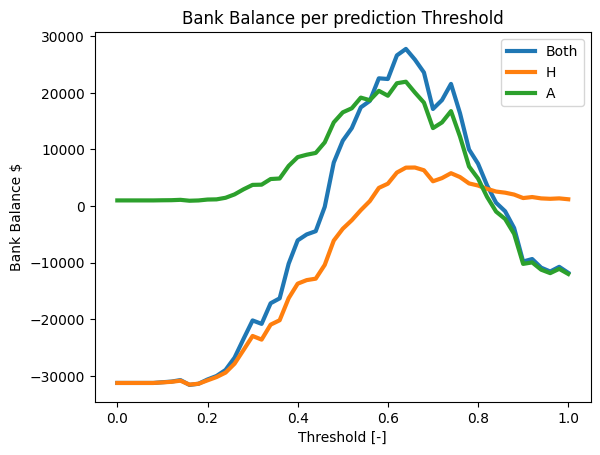

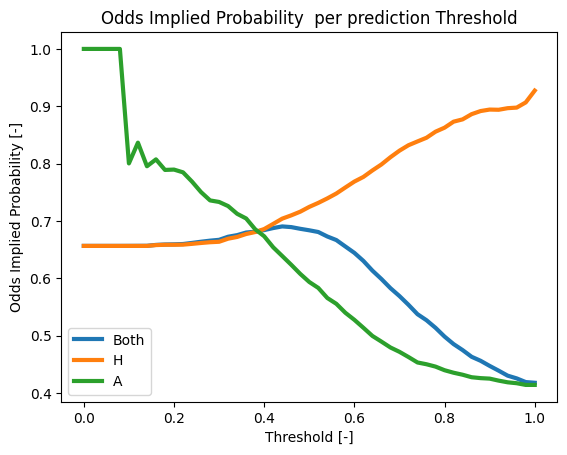

Max H: 6812.616
Max A: 21971.206


In [14]:
print("Ridge Regression - Train")
results_ridge_train = np.array(results_ridge_train)


plt.plot(thresholds, results_ridge_train[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_ridge_train[:, 1], lw=3, label="H")
plt.plot(thresholds, results_ridge_train[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_ridge_train[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_ridge_train[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_ridge_train[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_ridge_train[:, 1]):.3f}\nMax A: {max(results_ridge_train[:, 2]):.3f}")


Ridge Regression - Test


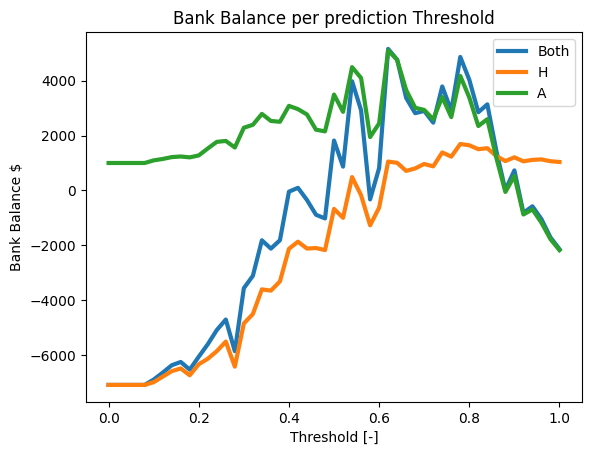

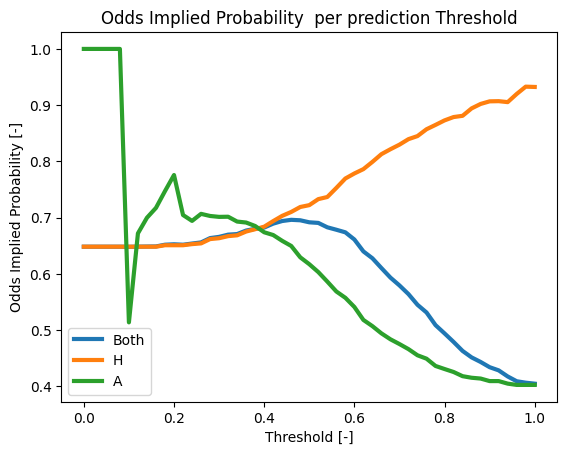

Max H: 1691.590
Max A: 5100.220


In [15]:
print("Ridge Regression - Test")
results_ridge_test = np.array(results_ridge_test)


plt.plot(thresholds, results_ridge_test[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_ridge_test[:, 1], lw=3, label="H")
plt.plot(thresholds, results_ridge_test[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_ridge_test[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_ridge_test[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_ridge_test[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_ridge_test[:, 1]):.3f}\nMax A: {max(results_ridge_test[:, 2]):.3f}")

Naive Bayes - Train


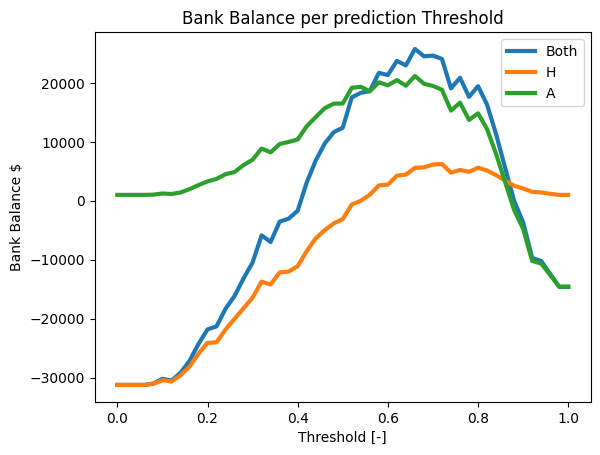

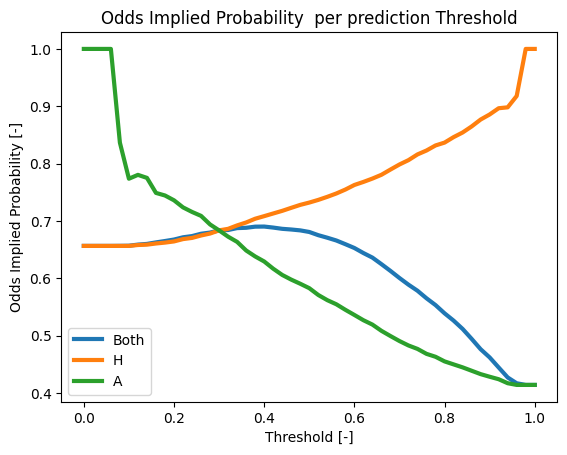

Max H: 6229.643
Max A: 21184.393


In [16]:
print("Naive Bayes - Train")
results_nb_train = np.array(results_nb_train)


plt.plot(thresholds, results_nb_train[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_nb_train[:, 1], lw=3, label="H")
plt.plot(thresholds, results_nb_train[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_nb_train[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_nb_train[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_nb_train[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_nb_train[:, 1]):.3f}\nMax A: {max(results_nb_train[:, 2]):.3f}")

Naive Bayes - Test


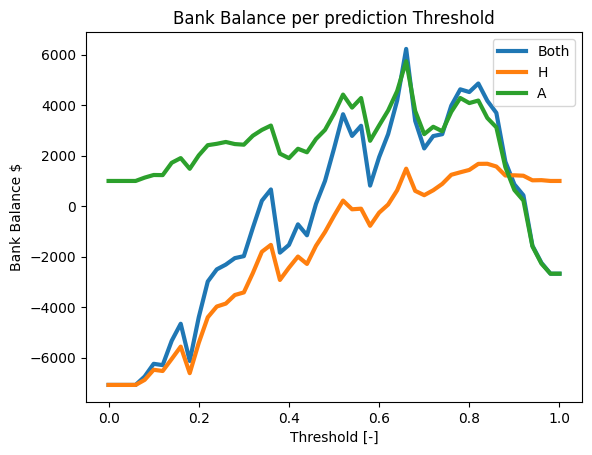

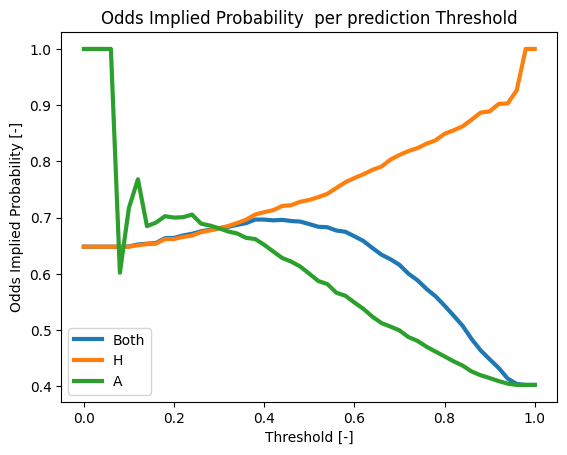

Max H: 1680.789
Max A: 5743.271


In [17]:
print("Naive Bayes - Test")
results_nb_test = np.array(results_nb_test)


plt.plot(thresholds, results_nb_test[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_nb_test[:, 1], lw=3, label="H")
plt.plot(thresholds, results_nb_test[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_nb_test[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_nb_test[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_nb_test[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_nb_test[:, 1]):.3f}\nMax A: {max(results_nb_test[:, 2]):.3f}")


Ridge Regression - Train - Kelly Strategy


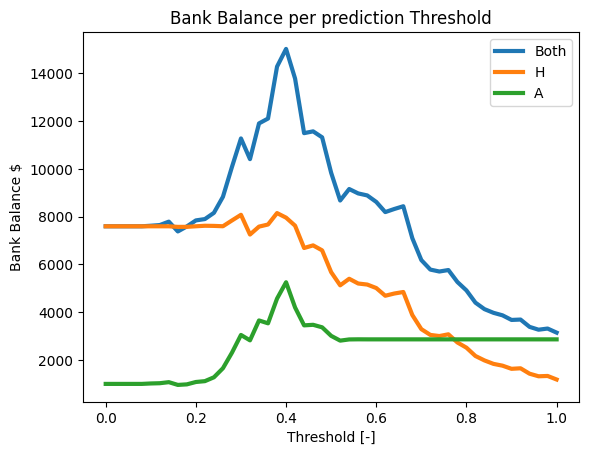

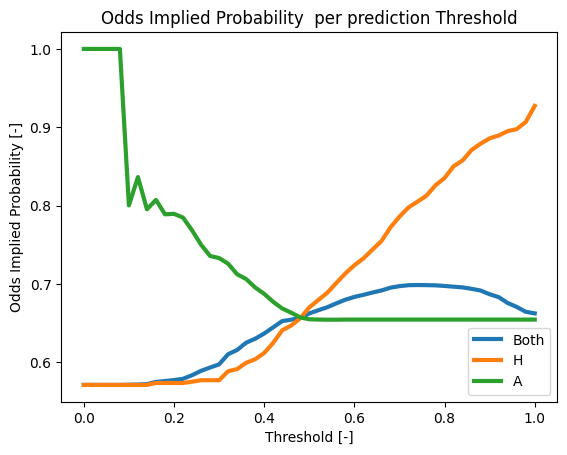

Max H: 8152.144
Max A: 5255.923


In [18]:
print("Ridge Regression - Train - Kelly Strategy")
results_kelly_ridge_train = np.array(results_kelly_ridge_train)


plt.plot(thresholds, results_kelly_ridge_train[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_kelly_ridge_train[:, 1], lw=3, label="H")
plt.plot(thresholds, results_kelly_ridge_train[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_kelly_ridge_train[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_kelly_ridge_train[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_kelly_ridge_train[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_kelly_ridge_train[:, 1]):.3f}\nMax A: {max(results_kelly_ridge_train[:, 2]):.3f}")

Ridge Regression - Test - Kelly Strategy


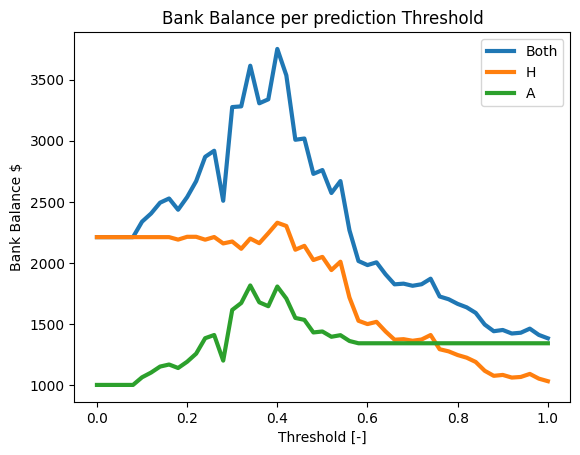

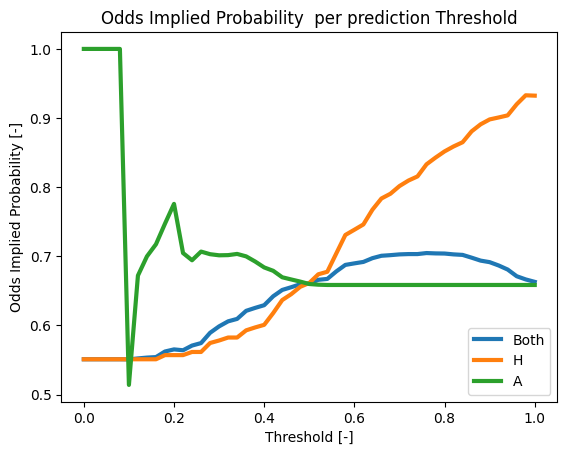

Max H: 2328.622
Max A: 1814.776


In [19]:
print("Ridge Regression - Test - Kelly Strategy")
results_kelly_ridge_test = np.array(results_kelly_ridge_test)


plt.plot(thresholds, results_kelly_ridge_test[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_kelly_ridge_test[:, 1], lw=3, label="H")
plt.plot(thresholds, results_kelly_ridge_test[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(thresholds, 1 / results_kelly_ridge_test[:, 3], lw=3, label="Both")
plt.plot(thresholds, 1 / results_kelly_ridge_test[:, 4], lw=3, label="H")
plt.plot(thresholds, 1 / results_kelly_ridge_test[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_kelly_ridge_test[:, 1]):.3f}\nMax A: {max(results_kelly_ridge_test[:, 2]):.3f}")

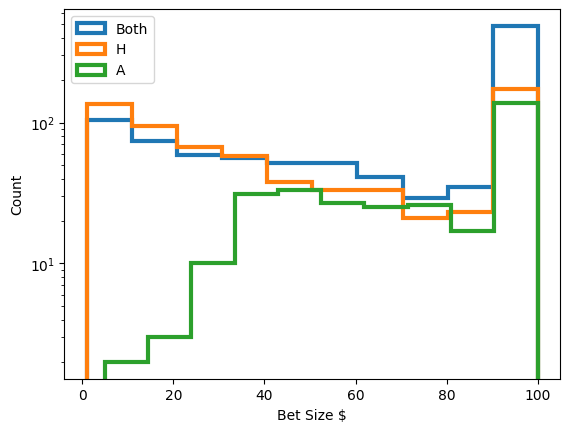

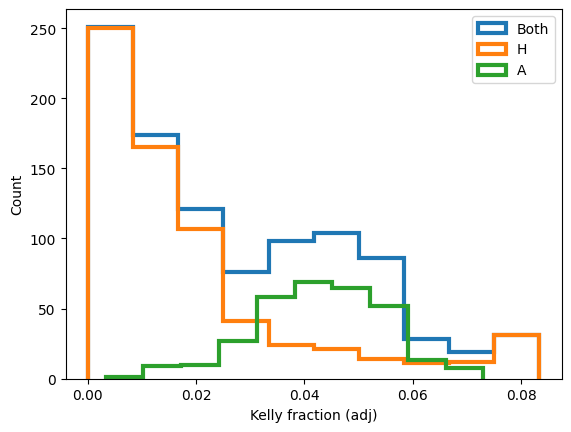

Min Kelly bet: 1.000
Max Kelly bet: 100.000
Min Kelly f: 0.000
Max Kelly f: 0.083


In [20]:
idx = np.argmax(results_kelly_ridge_train[:, 1])

plt.hist(bets_kelly_ridge_train[idx][0], histtype="step", lw=3, label="Both")
plt.hist(bets_kelly_ridge_train[idx][1], histtype="step", lw=3, label="H")
plt.hist(bets_kelly_ridge_train[idx][2], histtype="step", lw=3, label="A")
plt.yscale("log")
plt.xlabel("Bet Size $")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.hist(bets_kelly_ridge_train[idx][3], histtype="step", lw=3, label="Both")
plt.hist(bets_kelly_ridge_train[idx][4], histtype="step", lw=3, label="H")
plt.hist(bets_kelly_ridge_train[idx][5], histtype="step", lw=3, label="A")
plt.ylabel("Count")
plt.xlabel("Kelly fraction (adj)")
plt.legend()
plt.show()

print(f"Min Kelly bet: {min(bets_kelly_ridge_train[idx][1]):.3f}\nMax Kelly bet: {max(bets_kelly_ridge_train[idx][1]):.3f}")
print(f"Min Kelly f: {min(bets_kelly_ridge_train[idx][3]):.3f}\nMax Kelly f: {max(bets_kelly_ridge_train[idx][3]):.3f}")

Naive Bayes - Train - Kelly Strategy


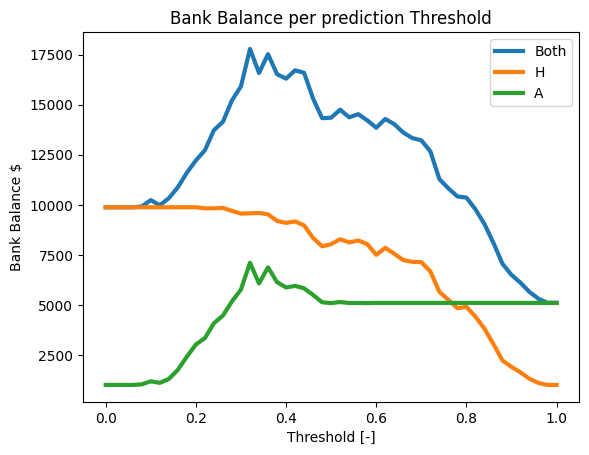

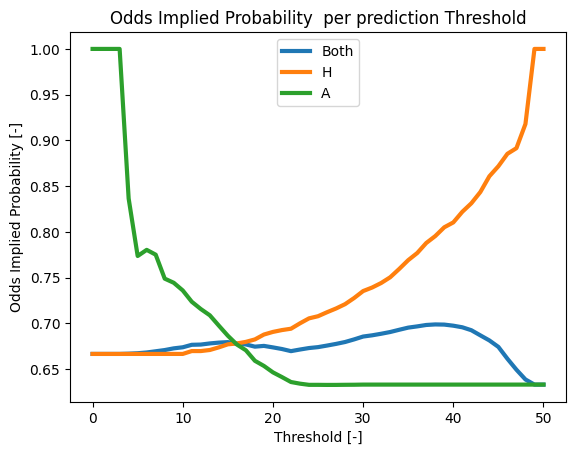

Max H: 9878.363
Max A: 7102.920


In [21]:
print("Naive Bayes - Train - Kelly Strategy")
results_kelly_nb_train = np.array(results_kelly_nb_train)


plt.plot(thresholds, results_kelly_nb_train[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_kelly_nb_train[:, 1], lw=3, label="H")
plt.plot(thresholds, results_kelly_nb_train[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(1 / results_kelly_nb_train[:, 3], lw=3, label="Both")
plt.plot(1 / results_kelly_nb_train[:, 4], lw=3, label="H")
plt.plot(1 / results_kelly_nb_train[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_kelly_nb_train[:, 1]):.3f}\nMax A: {max(results_kelly_nb_train[:, 2]):.3f}")

Naive Bayes - Test - Kelly Strategy


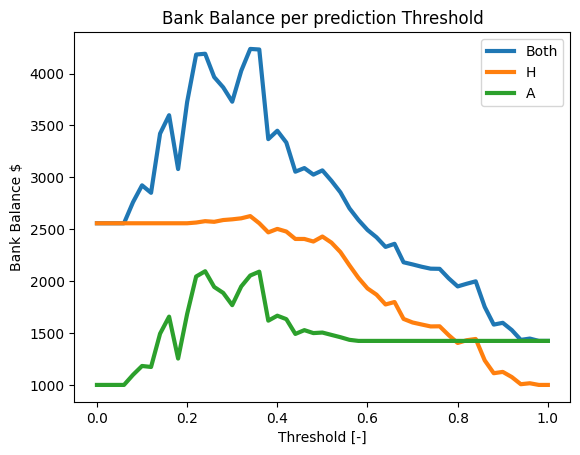

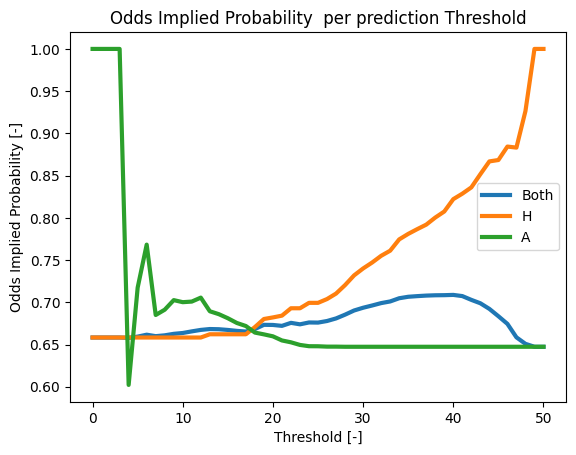

Max H: 2626.870
Max A: 2095.510


In [22]:
print("Naive Bayes - Test - Kelly Strategy")
results_kelly_nb_test = np.array(results_kelly_nb_test)


plt.plot(thresholds, results_kelly_nb_test[:, 0], lw=3, label="Both")
plt.plot(thresholds, results_kelly_nb_test[:, 1], lw=3, label="H")
plt.plot(thresholds, results_kelly_nb_test[:, 2], lw=3, label="A")
plt.legend()
plt.ylabel("Bank Balance $")
plt.xlabel("Threshold [-]")
plt.title("Bank Balance per prediction Threshold")
plt.show()

plt.plot(1 / results_kelly_nb_test[:, 3], lw=3, label="Both")
plt.plot(1 / results_kelly_nb_test[:, 4], lw=3, label="H")
plt.plot(1 / results_kelly_nb_test[:, 5], lw=3, label="A")
plt.ylabel("Odds Implied Probability [-]")
plt.xlabel("Threshold [-]")
plt.title("Odds Implied Probability  per prediction Threshold")
plt.legend()
plt.show()

print(f"Max H: {max(results_kelly_nb_test[:, 1]):.3f}\nMax A: {max(results_kelly_nb_test[:, 2]):.3f}")




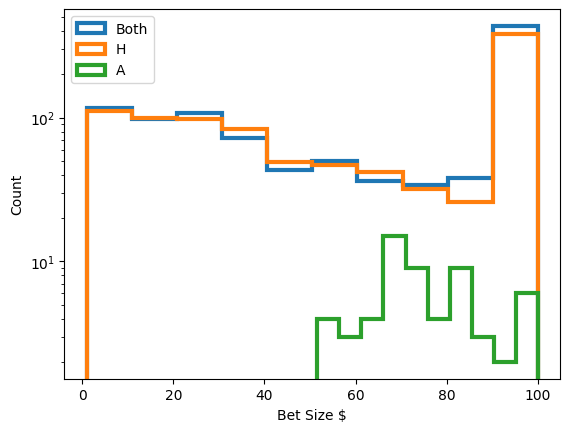

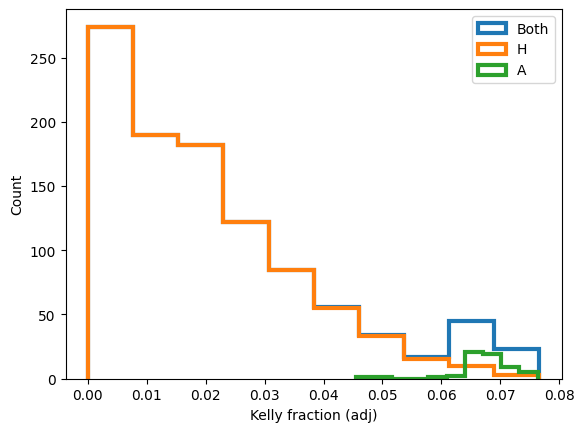

Min Kelly bet: 1.000
Max Kelly bet: 100.000
Min Kelly f: 0.000
Max Kelly f: 0.077


In [23]:
idx = np.argmax(results_kelly_nb_train[:, 1])

plt.hist(bets_kelly_nb_train[idx][0], histtype="step", lw=3, label="Both")
plt.hist(bets_kelly_nb_train[idx][1], histtype="step", lw=3, label="H")
plt.hist(bets_kelly_nb_train[idx][2], histtype="step", lw=3, label="A")
plt.yscale("log")
plt.xlabel("Bet Size $")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.hist(bets_kelly_nb_train[idx][3], histtype="step", lw=3, label="Both")
plt.hist(bets_kelly_nb_train[idx][4], histtype="step", lw=3, label="H")
plt.hist(bets_kelly_nb_train[idx][5], histtype="step", lw=3, label="A")
plt.ylabel("Count")
plt.xlabel("Kelly fraction (adj)")
plt.legend()
plt.show()

print(f"Min Kelly bet: {min(bets_kelly_nb_train[idx][1]):.3f}\nMax Kelly bet: {max(bets_kelly_nb_train[idx][1]):.3f}")
print(f"Min Kelly f: {min(bets_kelly_nb_train[idx][3]):.3f}\nMax Kelly f: {max(bets_kelly_nb_train[idx][3]):.3f}")